#09. PyTorch Model Deployment
What is model deployment?

Machine learning model deployment is the act of making your machine learning model(s) available to someone or something else.

การนำโมเดลไปใช้งาน (Model Deployment) หมายถึง การทำให้โมเดลแมชชีนเลิร์นนิ่งของคุณพร้อมใช้งานสำหรับบุคคลอื่นหรือระบบอื่น

Resources:
* book version of notebook: https://www.learnpytorch.io/09_pytorch_model_deployment/
* Slides: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/09_pytorch_model_deployment.pdf

##0. Get setup

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 253 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 27.96 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [ ]:
!ls going_modular/going_modular

data_setup.py  model_builder.py  __pycache__  train.py
engine.py      predictions.py	 README.md    utils.py


##1. Getting Data
The dataset we're going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101, random 20% of samples)

We can get data with code from: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [ ]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
# Setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

##2. FoodVision Mini model deployment experiment outline
###3 questions
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

###FoodVision Mini ideal use case: A model that performs well and fast.

1. Performs well: 95%+ accuracy
2. Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency)
  * Latency = time for prediction to take place

To try and achieve these goals, we're going to build two model experiments:

1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Paper Replicating)

##3. Creating an EffNetB2 feature extractor
Feautre extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

EffNetB2 pretrained model in PyTorch - https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights

In [ ]:
import torchvision

# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" is equivalent to saying "best available"

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters():
  param.requires_grad = False

In [ ]:
from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output)
# summary(effnetb2,
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [ ]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)

In [ ]:
# Set seeds for reproducibility
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True))


###3.1 Creating a function to make an EffNetB2 feature extractor

In [ ]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  # 1. Setup pretrained EffNetB2 weights
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" is equivalent to saying "best available"
  # 2. Get EffNetB2 transforms
  transforms = weights.transforms()
  # 3. Setup pretrained model instance
  model = torchvision.models.efficientnet_b2(weights=weights) # could also use weights="DEFAULT"
  # 4. Freeze the base layers in the model (this will stop all layers from training)
  for param in model.parameters():
    param.requires_grad = False
  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes, bias=True))
  return model, transforms

In [ ]:
effnetb2_model, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                            seed=42)

In [ ]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# from torchinfo import summary

# # Print EffNetB2 model summary (uncomment for full output)
# summary(effnetb2,
#         input_size=(1, 3, 288, 288),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

###3.2 Creating DataLoaders for EffNetB2

In [ ]:
#create dataloader
from going_modular.going_modular import data_setup
train_dataloader_effentb2,test_dataloader_effentb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                 test_dir=test_dir,
                                                 transform=effnetb2_transforms,
                                                 batch_size=32)

In [ ]:
len(train_dataloader_effentb2),len(test_dataloader_effentb2),class_names

(15, 5, ['pizza', 'steak', 'sushi'])

###3.3 Training EffNetB2 feature extractor

In [ ]:
from going_modular.going_modular import engine
#loss function
loss_fn = nn.CrossEntropyLoss()
#optimizer
optimizer = torch.optim.Adam(params=effnetb2_model.parameters(),
                             lr=1e-3)
#training

set_seeds()
effnetb2_model_results = engine.train(model=effnetb2_model,
                                       train_dataloader=train_dataloader_effentb2,
                                       test_dataloader=test_dataloader_effentb2,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn,
                                       epochs=10,
                                       device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


###3.4 Inspecting EffNetB2 loss curves

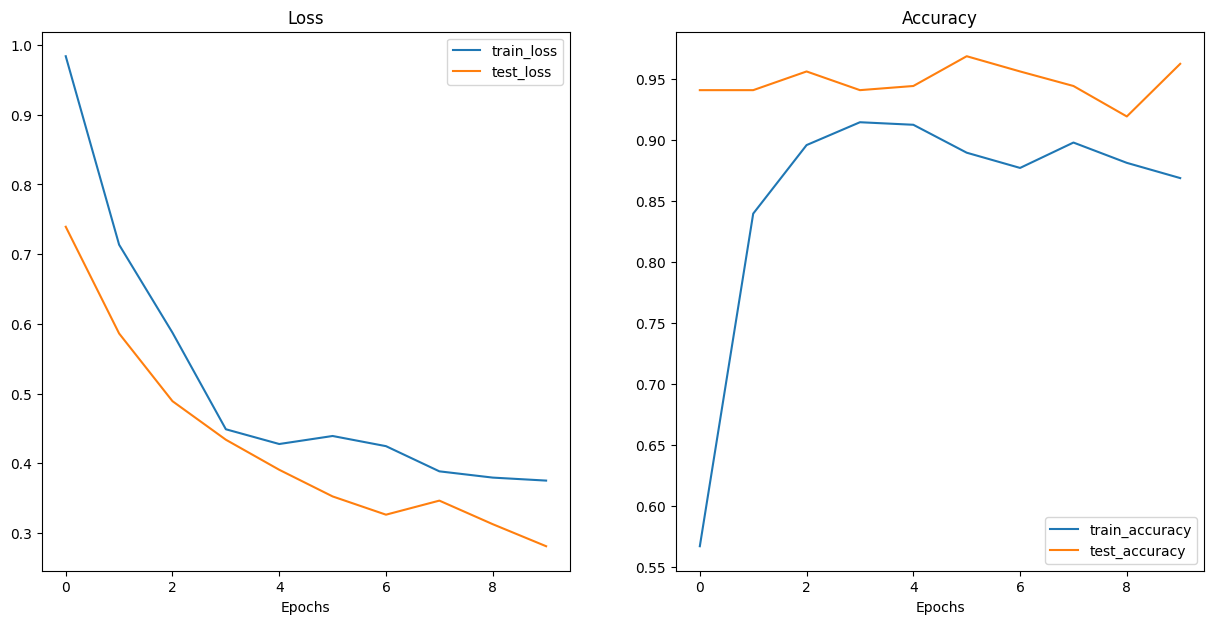

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_model_results)

See here for what an ideal loss curve should look like: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

###3.5 Saving EffNetB2 feature extractor

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2_model,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


###3.6 inspecting the size of EffNetB2 feature extractor
Why would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resources.

So if our model file is too large, we may not be able to store/run it on our target device.

In [ ]:
from pathlib import Path
# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB")

Pretrained EffNetB2 feature extractor model size: 29.86 MB


###3.7 Collecting EffNetB2 feature extractor stats

In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_model_results["test_loss"][-1],
                  "test_acc": effnetb2_model_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166}

##4. Creating an viT feature extractor
We're up to our second modelling experiment, repeating the steps for EffNetB2 but this time with a ViT feature extractor, see here for ideas: https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-using-a-pretrained-vit-from-torchvisionmodels-on-the-same-dataset

In [ ]:
# Check out the ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

In [ ]:
def create_vit_model(num_classes:int=3,
              seed:int=42):
  # 1. Get pretrained weights for ViT-Base
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available
  transforms = weights.transforms()
  # 2. Setup a ViT model instance with pretrained weights
  model = torchvision.models.vit_b_16(weights=weights).to(device)

  # 3. Freeze the base parameters
  for parameter in model.parameters():
      parameter.requires_grad = False

  # 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  model.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
  # pretrained_vit # uncomment for model output
  return model, transforms

In [ ]:
vit_model, vit_transforms = create_vit_model()
vit_transforms

In [ ]:

from torchinfo import summary

# Print ViT model summary (uncomment for full output)
summary(vit_model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

###4.1 Create DataLoaders for ViT feature extractor

In [ ]:
# Setup vit dataloaders
from going_modular.going_modular import data_setup
train_dataloader_vit_pretrained, test_dataloader_vit_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
len(train_dataloader_vit_pretrained),len(test_dataloader_vit_pretrained),class_names

###4.2 Training ViT Feature Extractor
We're up to model experiment number two: a ViT feature extractor.

In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=vit_model.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=vit_model,
                                      train_dataloader=train_dataloader_vit_pretrained,
                                      test_dataloader=test_dataloader_vit_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

###4.3 Plot loss curves of ViT feature extractor

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

For more on what an ideal loss curves should look like see here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

###4.4 Saving ViT feature extractor

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=vit_model,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

In [ ]:
from pathlib import Path
# Get the model size in bytes and convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained vit feature extractor model size: {round(pretrained_vit_model_size, 2)} MB")

In [ ]:
# Count number of parameters in vit
vit_total_params = sum(torch.numel(param) for param in vit_model.parameters())
vit_total_params

In [ ]:
# Create a dictionary with EffNetB2 statistics
vit_stats = {"test_loss": pretrained_vit_results["test_loss"][-1],
                  "test_acc": pretrained_vit_results["test_acc"][-1],
                  "number_of_parameters": vit_total_params,
                  "model_size (MB)": pretrained_vit_model_size}

vit_stats

##5. Making predictions with our trained models and timing them

Our goal:

  1. Performs well (95%+ test accuracy)
  2. Fast (30+FPS)
  
To test criteria two:

  1. Loop through test images
  2. Time how long each model takes to make a prediction on the image

Let's work towards making a function called `pred_and_store()` to do so.

First we'll need a list of test image paths.


In [ ]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1523026.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2061929.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/86782.jpg')]

###5.1 Creating a function to make across the test dataset

Steps to create `pred_and_store()`:

1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take place inside the loop).
4. Create an empty dictionary for each sample (prediction statistics will go in here).
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer.
7. Open the image using PIL.Image.open(path).
8. Transform the image to be usable with a given model.
9. Prepare the model model for inference by sending to the target device and turning on eval() mode.
10. Turn on torch.inference_mode() and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empty dictionary from step 4.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
15. Return the list of prediction dictionaries.


In [ ]:
"""py
def บันทึกผลการทำนาย():
1. สร้างฟังก์ชันที่รับรายการ paths, โมเดล PyTorch ที่ผ่านการฝึก, ชุด transforms, รายการชื่อคลาสเป้าหมาย และ target device
2. สร้างลิสต์ว่าง (เพื่อเก็บผลการทำนายทั้งหมด)
3. วนลูปในรายการ paths ที่ต้องการประมวลผล
4. สร้างดิกชันนารีว่างสำหรับแต่ละตัวอย่าง (เพื่อเก็บข้อมูลการทำนาย)
5. ดึง path และคลาสจริง (ground truth) จาก filepath
6. เริ่มตัวจับเวลา (timer)
7. เปิดภาพโดยใช้ `PIL.Image.open(path)`
8. ทำการแปลงภาพให้เหมาะสมกับโมเดล
9. เตรียมโมเดลสำหรับการ inference โดยส่งไปยัง target device และตั้งค่าเป็น `eval()`
10. ใช้ `torch.inference_mode()` และส่งภาพที่แปลงแล้วเข้าสู่โมเดลเพื่อคำนวณผลลัพธ์ + ความน่าจะเป็น (pred prob) + คลาสที่ทำนาย (pred class)
11. เพิ่มข้อมูลความน่าจะเป็น + คลาสที่ทำนายลงในดิกชันนารีที่สร้างไว้ในข้อ 4
12. หยุดจับเวลาที่เริ่มในข้อ 6 และเพิ่มเวลาในดิกชันนารี
13. ตรวจสอบว่าคลาสที่ทำนายตรงกับคลาสจริงหรือไม่
14. เพิ่มดิกชันนารีที่อัปเดตแล้วไปในลิสต์ผลการทำนายที่สร้างในข้อ 2
15. ส่งคืนลิสต์ของดิกชันนารีผลการทำนาย
"""

In [ ]:
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict
import torchvision.transforms as transforms

# 1. สร้างฟังก์ชันที่รับรายการ paths, โมเดล PyTorch ที่ผ่านการฝึก, ชุด transforms, รายการชื่อคลาสเป้าหมาย และ target device
def pred_and_store(model: torch.nn.Module,
                  target_paths: List[pathlib.Path],
                  transforms: transforms.Compose,
                  class_names: List[str],
                  device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  # 2. สร้างลิสต์ว่าง (เพื่อเก็บผลการทำนายทั้งหมด)
  pred_list = []
  # 3. วนลูปในรายการ paths ที่ต้องการประมวลผล
  for path in tqdm(target_paths):
    # 4. สร้างดิกชันนารีว่างสำหรับแต่ละตัวอย่าง (เพื่อเก็บข้อมูลการทำนาย)
    pred_dict = {}
    # 5. ดึง path และ ground truth class (ground truth = "คำเฉลยคำตอบ") จาก filepath
    pred_dict["image_path"] = path
    pred_dict["ground_truth_class"] = path.parent.stem # `parent` ใช้สำหรับดึงชื่อโฟลเดอร์
    # 6.
    start_time = timer()
    # 7. เปิดภาพโดยใช้ `PIL.Image.open(path)`
    img = Image.open(path)
    # 8. ทำการแปลงภาพให้เหมาะสมกับโมเดล
    transformed_image = transforms(img).unsqueeze(0).to(device)
    # 9. ย้ายโมเดลไปที่ device ก่อนเริ่มลูป
    model = model.to(device)
    model.eval()
    # 10. ใช้ `torch.inference_mode()` และส่งภาพที่แปลงแล้วเข้าสู่โมเดลเพื่อคำนวณผลลัพธ์ + ความน่าจะเป็น (pred prob) + คลาสที่ทำนาย (pred class)
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1) # แปลงค่า logits ให้เป็นค่าความน่าจะเป็นของการทำนาย
      pred_label = torch.argmax(pred_prob, dim=1)  # แปลงค่าความน่าจะเป็นของการทำนายให้เป็นป้ายกำกับการทำนาย
      pred_class = class_names[pred_label.cpu()] # การกำหนดคลาสการทำนายให้ทำงานบน CPU (ตัวแปรใน Python จะถูกจัดเก็บอยู่บน CPU)
    # 11. เพิ่มข้อมูลความน่าจะเป็น + คลาสที่ทำนายลงในดิกชันนารีที่สร้างไว้ในข้อ 5
    pred_dict["pred_prob"] = round(pred_prob.squeeze(0).max().cpu().item(), 4)
    pred_dict["pred_class"] = pred_class
    # 12. หยุดจับเวลาที่เริ่มในข้อ 6 และเพิ่มเวลาในดิกชันนารี
    end_timer = timer()
    pred_dict["prediction_time"] = round(end_timer - start_time, 4)
    # 13. ตรวจสอบว่าคลาสที่ทำนายตรงกับคลาสจริงหรือไม่
    pred_dict["correct"] = pred_dict["ground_truth_class"] == pred_class
    # 14. เพิ่มดิกชันนารีที่อัปเดตแล้วไปในลิสต์ผลการทำนายที่สร้างไว้ในข้อ 2
    pred_list.append(pred_dict)

  # 15. คืนค่าลิสต์ผลการทำนาย
  return pred_list


###5.2 Making and timing predictions with EffNetB2
การสร้างและจับเวลาการทำนาย

Let's test our pred_and_store() function.

Two things to note:

  1. อุปกรณ์ - เราจะกำหนดให้การทำนายเกิดขึ้นบน CPU โดยตรง (เพราะเมื่อคุณนำโมเดลไปใช้งาน อาจไม่มี GPU ใช้เสมอไป)  
  2. การแปลงข้อมูล - เราต้องแน่ใจว่าแต่ละโมเดลได้รับภาพที่ถูกแปลงให้เหมาะสมกับโมเดลนั้น ๆ (เช่น EffNetB2 ใช้ effnetb2_transforms)  

In [ ]:
#predict effenb2
effnetb2_test_pred_dicts  = pred_and_store(model = effnetb2_model,
                         target_paths = test_data_paths,
                         transforms = effnetb2_transforms,
                         class_names = class_names,
                         device = "cpu")


  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg'),
  'ground_truth_class': 'steak',
  'pred_prob': 0.948,
  'pred_class': 'steak',
  'prediction_time': 0.3929,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1523026.jpg'),
  'ground_truth_class': 'steak',
  'pred_prob': 0.7299,
  'pred_class': 'steak',
  'prediction_time': 0.1303,
  'correct': True}]

In [ ]:
#turn the effnetb2_test_pred_dicts into dataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,ground_truth_class,pred_prob,pred_class,prediction_time,correct
0,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9480,steak,0.3929,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.7299,steak,0.1303,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9221,steak,0.1149,True
3,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.9056,steak,0.1034,True
4,data/pizza_steak_sushi_20_percent/test/steak/8...,steak,0.7961,steak,0.1030,True


In [ ]:
#check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,144
False,6


In [ ]:
#find the avg time per prediction
effnetb2_average_time_per_pred  = round(effnetb2_test_pred_df.prediction_time.mean(),4)
print(f"avg per sec. predition : {effnetb2_average_time_per_pred}")

avg per sec. predition : 0.1101


In [ ]:
# Add time per pred to EffNetB2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8638858795166,
 'time_per_pred_cpu': 0.1101}

***Note:*** เวลาที่ใช้ในการทำนายจะแตกต่างกันไป (คล้ายกับเวลาฝึกโมเดล) ขึ้นอยู่กับฮาร์ดแวร์ที่คุณใช้งาน... โดยทั่วไปแล้ว ฮาร์ดแวร์ที่ประมวลผลเร็วกว่า (เช่น CPU หรือ GPU) จะทำให้การทำนายเกิดขึ้นได้เร็วขึ้น

###5.3 Making and timing predictions with ViT

In [ ]:
vit_test_pred_dicts  = pred_and_store(model = vit_model,
                         target_paths = test_data_paths,
                         transforms = vit_transforms,
                         class_names = class_names,
                         device = "cpu")

In [ ]:
vit_test_pred_dicts[:2]

In [ ]:
#turn the effnetb2_test_pred_dicts into dataFrame
import pandas as pd
vit_test_pred_dicts = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_dicts.head()

In [ ]:
#check number of correct predictions
vit_test_pred_dicts.correct.value_counts()

In [ ]:
#find the avg time per prediction
vit_average_time_per_pred  = round(vit_test_pred_dicts.prediction_time.mean(),4)
print(f"avg per sec. predition : {vit_average_time_per_pred}")

In [ ]:
# Add average time per prediction to ViT stats
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

##6. Comparing model results, prediction times and size

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

โมเดลไหนดีกว่ากัน?

* `test_loss` (ยิ่งน้อยยิ่งดี) - ViT  
* `test_acc` (ยิ่งสูงยิ่งดี) - ViT  
* `number_of_parameters` (โดยทั่วไปยิ่งน้อยยิ่งดี*) - EffNetB2 (ถ้าโมเดลมีพารามิเตอร์มากขึ้น การคำนวณมักใช้เวลานานขึ้น)  
  * บางครั้งโมเดลที่มีพารามิเตอร์สูงอาจยังคงทำงานได้เร็ว  
* `model_size (MB)` - EffNetB2 (สำหรับกรณีของเราที่ต้องการใช้งานบนอุปกรณ์พกพา โดยทั่วไปยิ่งขนาดเล็กยิ่งดี)  
* `time_per_pred_cpu` (ยิ่งน้อยยิ่งดี ขึ้นอยู่กับฮาร์ดแวร์ที่ใช้งาน) - EffNetB2  

ทั้งสองโมเดลยังไม่สามารถบรรลุเป้าหมาย 30+ FPS ได้... แต่เราสามารถลองใช้ EffNetB2 ดูก่อนและตรวจสอบผลลัพธ์ได้.

In [ ]:
# เปรียบเทียบ ViT กับ EffNetB2 ในลักษณะต่างๆ
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

เปรียบเทียบ ViT กับ EffNetB2 ในลักษณะต่างๆ:

- **`test_loss` (ค่าความสูญเสียในการทดสอบ - ยิ่งต่ำยิ่งดี):**  
  - **ViT** ดีกว่า  

- **`test_acc` (ความแม่นยำในการทดสอบ - ยิ่งสูงยิ่งดี):**  
  - **ViT** ดีกว่า  

- **`number_of_parameters` (จำนวนพารามิเตอร์ - โดยทั่วไปยิ่งน้อยยิ่งดี):**  
  - **EffNetB2** ดีกว่า  

- **`model_size (MB)` (ขนาดโมเดล - ยิ่งเล็กยิ่งดีสำหรับการใช้งานบนอุปกรณ์พกพา):**  
  - **EffNetB2** ดีกว่า  

- **`time_per_pred_cpu` (เวลาในการทำนายบน CPU - ยิ่งต่ำยิ่งดี):**  
  - **EffNetB2** ดีกว่า  

###### 6.1 การแสดงภาพเปรียบเทียบความเร็วกับประสิทธิภาพ  

ตอนนี้เราได้เปรียบเทียบโมเดล **EffNetB2** และ **ViT** (feature extractor) แล้ว เราสามารถแสดงผลการเปรียบเทียบผ่านกราฟ **speed vs. performance** ได้โดยใช้ Matplotlib:

1. สร้าง **scatter plot** จาก DataFrame ที่มีข้อมูลการเปรียบเทียบ เพื่อแสดงผลระหว่าง **test accuracy** และ **prediction time** ของโมเดล EffNetB2 และ ViT  
2. เพิ่มหัวข้อและป้ายกำกับ (titles และ labels) เพื่อทำให้กราฟดูเข้าใจง่ายขึ้น  
3. ใส่คำอธิบาย (annotate) ลงบนจุดต่างๆ ใน scatter plot เพื่อระบุว่าเป็นโมเดลใด  
4. สร้าง legend ที่แสดงขนาดของโมเดล (model_size (MB)) เพื่อเพิ่มรายละเอียดในการเปรียบเทียบ  

In [ ]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

# 2. Add titles and labels to make our plot look good
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# 3. Annotate the samples on the scatter plot so we know what's going on.
for index, row in df.iterrows():
  ax.annotate(text=row["model"], # note: in some versions of Matplotlib, this may need to be "text" rather than "s"
              xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
              size=12)

# 4. Create a legend based on the model sizes (model_size (MB)).
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.png")

### 7. การนำ **FoodVision Mini** มาใช้งานจริงโดยสร้าง Gradio Demo  

เราเลือกใช้ **EffNetB2** เพราะตรงตามเกณฑ์ของเรามากที่สุด  

#### Gradio คืออะไร?  
  * Gradio เป็นเครื่องมือที่ช่วยสร้างเดโมของโมเดล Machine Learning ได้อย่างรวดเร็ว ด้วยอินเทอร์เฟซแบบเว็บที่ใช้งานง่าย ทำให้ทุกคนสามารถทดลองใช้ได้ทุกที่!  
  สามารถศึกษาข้อมูลเพิ่มเติมได้ที่: [https://gradio.app/](https://gradio.app/)

For FoodVision Mini, we're going to be working towards building something like this: https://huggingface.co/spaces/mrdbourke/foodvision_mini

In [ ]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.4 MB/s eta 0:00:00
Gradio version: 5.6.0


### 7.1 ภาพรวมของ Gradio  
Gradio ช่วยให้คุณสร้างเดโมสำหรับโมเดล Machine Learning ได้  

#### ทำไมต้องสร้างเดโม?  
เพื่อให้คนอื่นสามารถทดลองใช้โมเดลของเรา และเพื่อทดสอบการทำงานในสถานการณ์จริง  

**การ Deploy โมเดลสำคัญพอๆ กับการ Train โมเดล**  

แนวคิดหลักของ Gradio คือการทำงานในรูปแบบ  
**inputs -> function/model -> outputs**  

In [ ]:
# Put our model on the CPU
effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')


Let's create a function called `predict()` to go from:

images of food -> ML model (EffNetB2) -> outputs (food class label, prediction time)

***สร้างฟังก์ชัน Predict เพื่อแมปอินพุตขนาดเล็กวิสัยทัศน์อาหารของเรากับเอาต์พุต***

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2_model.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probaiblities
    pred_probs = torch.softmax(effnetb2_model(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  # ความน่าจะเป็นการทำนาย (prediction probability)
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image
import requests
from pathlib import Path

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
print(f"Example test data path: {test_data_paths[0]}")

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

Example test data path: data/pizza_steak_sushi_20_percent/test/pizza/204151.jpg
[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/steak/1882831.jpg

{'pizza': 0.2415485382080078, 'steak': 0.506755530834198, 'sushi': 0.2516959011554718}
0.2484


###7.3 การสร้างรายการรูปภาพตัวอย่าง  
สามารถสร้างตัวอย่างสำหรับ Gradio ได้โดยใช้พารามิเตอร์ `examples` ดูรายละเอียดเพิ่มเติมได้ที่: https://gradio.app/docs/#building-demos

In [ ]:
#Create liss of examples input demo
example_list = [str(filepath) for filepath in random.sample(test_data_paths, k=3)]
example_list

['data/pizza_steak_sushi_20_percent/test/sushi/593071.jpg',
 'data/pizza_steak_sushi_20_percent/test/sushi/301603.jpg',
 'data/pizza_steak_sushi_20_percent/test/steak/3138001.jpg']

###7.4 Building a Gradio Interface
Let's use gr.Interface() to go from:
```
input: image -> transform -> predict with EffNetB2 -> output: pred, prob prob, time
```

In [ ]:
import gradio as gr

title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify food images into 3 classes: pizza, steak, sushi."
article = " Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#74-building-a-gradio-interface)."
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)
demo.launch(share=True,
            debug=False)

## 8. การเปลี่ยน FoodVision Mini Gradio Demo ให้เป็นแอปพลิเคชันที่สามารถนำไปใช้งานได้  
Gradio demos บน Google Colab นั้นยอดเยี่ยม แต่จะหมดอายุภายใน 72 ชั่วโมง  

เพื่อแก้ไขปัญหานี้ เราจะเตรียมไฟล์แอปของเราให้พร้อมสำหรับการโฮสต์บน **Hugging Face Spaces**: https://huggingface.co/docs/hub/spaces

### 8.1 Hugging Face Spaces คืออะไร?  

> Hugging Face Spaces เป็นวิธีที่ง่ายสำหรับการโฮสต์แอปสาธิต ML โดยตรงบนโปรไฟล์ของคุณหรือโปรไฟล์ขององค์กรของคุณ ช่วยให้คุณสร้างพอร์ตโฟลิโอ ML แสดงโครงการในงานประชุมหรือกับผู้ที่เกี่ยวข้อง และทำงานร่วมกันกับคนอื่น ๆ ในวงการ ML  

ถ้า GitHub เป็นที่แสดงความสามารถในการเขียนโค้ด Hugging Face Spaces ก็เปรียบเสมือนสถานที่แสดงความสามารถด้าน Machine Learning (ผ่านการแชร์ ML demos ที่คุณสร้างขึ้น)  

### 8.2 โครงสร้างของแอป Gradio ที่ถูก Deploy  

มาเริ่มจัดเก็บไฟล์ทั้งหมดของแอปในไดเรกทอรีเดียว:  

1. จาก Colab -> โฟลเดอร์ที่รวมไฟล์ Gradio ทั้งหมด  
2. อัปโหลดไฟล์ของแอปไปยัง Hugging Face Spaces  
3. ทำการ Deploy  

เมื่อเสร็จสิ้น โครงสร้างไฟล์จะมีลักษณะดังนี้:  
```py
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```
ทำไมต้องใช้โครงสร้างนี้?

เพราะเป็นโครงสร้างที่ง่ายที่สุดสำหรับการเริ่มต้น

คุณสามารถดูการทำงานได้ที่:

Deployed app - https://huggingface.co/spaces/mrdbourke/foodvision_mini
See the example file structure - https://huggingface.co/spaces/mrdbourke/foodvision_mini/tree/main


###8.3 Creating a demos folder to store our FoodVision app files

In [ ]:
import shutil
from pathlib import Path

#Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

#Remove files than might exist and create a new directorty (ถ้ามีไฟล์เก่าให้ลบและสร้างใหม่)
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)
!ls demos/foodvision_mini/

###8.4 Creating a folder of example images to use with our FoodVision Mini demo
What we want:

  * 3 images in an examples/ directory
  * Images should be from the test set

In [ ]:
import shutil
from pathlib import Path

# create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# collect tree random test dataset img paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]
# copy the three img to examples directory
for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy(src=example,
              dst=foodvision_mini_examples_path)

Let's now verify that we can get a list of lists from our `examples/` directory.

In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

NameError: name 'foodvision_mini_examples_path' is not defined

###8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [ ]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the model file
try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

  # Move the movel
  shutil.move(src=effnetb2_foodvision_mini_model_path,
              dst=effnetb2_foodvision_mini_model_destination)

  print(f"[INFO] Model move complete.")
# If the model has already been moved, check if it exists
except:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
  print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")


NameError: name 'foodvision_mini_demo_path' is not defined

In [ ]:
#move model to demos folder this is short
# import shutil
# shutil.copy(src="models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
#             dst=foodvision_mini_demo_path)

###8.6 Turning off EffNetB2 model into a Python script (model.py)
We have a saved .pth model state_dict and want to load it into a model instance.

Let's move our `create_effnetb2_model()` function to a script so we can reuse it.

In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision
from torch import nn

# Create EffNetB2 feature extractor model
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  # 1. Setup pretrained EffNetB2 weights
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" is equivalent to saying "best available"
  # 2. Get EffNetB2 transforms
  transforms = weights.transforms()
  # 3. Setup pretrained model instance
  model = torchvision.models.efficientnet_b2(weights=weights) # could also use weights="DEFAULT"
  # 4. Freeze the base layers in the model (this will stop all layers from training)
  for param in model.parameters():
    param.requires_grad = False
  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True))
  return model, transforms


Writing demos/foodvision_mini/model.py


### 8.7 Turning our FoodVision Mini Gradio app into a Python script (app.py)
The app.py file will have four major parts:

  1. Imports and class names setup
  2. Model and transforms preparation
  3. Predict function `( predict() )`
  4. Gradio app - our Gradio interface + launch command

In [ ]:
%%writefile demos/foodvision_mini/app.py

# 1. imports and class names setup
import gradio as gr
import os
import torch
import torchvision

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

# 2. model and transforms preparation
effnetb2_model, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names),
                                                        seed=42)
# Load saved weights
effnetb2_model.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu") # load the model to the CPU
    )
)

# 3.predict function (predict())
def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2_model.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probaiblities
    pred_probs = torch.softmax(effnetb2_model(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  # ความน่าจะเป็นการทำนาย (prediction probability)
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

#create a example list
example_list = ["examples/" + example for example in os.listdir("examples")]
example_list

# Launch Gradio demo
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify food images into 3 classes: pizza, steak, sushi."
article = " Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#74-building-a-gradio-interface)."
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)
demo.launch(debug=False)


Writing demos/foodvision_mini/app.py


### 8.8 Creating a requirements file for FoodVision Mini (requirements.txt)
The requirements file will tell our Hugging Face Space what software dependencies our app requires.

The three main ones are:

  * torch
  * torchvision
  * gradio

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.5.1
torchvision==0.20.1
gradio==5.6.0

Writing demos/foodvision_mini/requirements.txt


##9. Deploying our FoodVision Mini app HuggingFace Spaces
There are two main options for uploading to a Hugging Face Space (also called a Hugging Face Repository, similar to a git repository):

  * Uploading via the Hugging Face Web interface (easiest).
  * Uploading via the command line or terminal.
    * Bonus: You can also use the huggingface_hub library to interact with Hugging Face, this would be a good extension to the above two options.

###9.1 Downloading our FoodVision Mini app files
We want to download our foodvision_mini demo app so we can upload it to Hugging Face Spaces.

In [ ]:
!ls demos/foodvision_mini

app.py	model.py  requirements.txt


In [ ]:
# Change into the foodvision_mini directory and then zip it from the inside
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.ipynb" "*.pyc" "*.__pycahe__" "*.ipynb_checkpoints"


In [ ]:
# #Download
# try:
#   from google.colab import files
#   files.download("demos/foodvision_mini.zip")
# except:
#   print("Skipping file download, not on Google Colab, pls download manually!")

###9.2 Running our Gradio demo app locally
Running the app locally - https://www.learnpytorch.io/09_pytorch_model_deployment/#92-running-our-foodvision-mini-demo-locally

###9.3 Uploading our FoodVision Mini Gradio demo to Hugging Face Spaces
See the steps here - https://www.learnpytorch.io/09_pytorch_model_deployment/#93-uploading-to-hugging-face

See the live app deployed here - https://raksitkan-foodvision-mini-video.hf.space

We can also share our app by embedding it: https://www.gradio.app/guides/sharing-your-app#embedding-hosted-spaces

In [ ]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://raksitkan-foodvision-mini-video.hf.space/+", width=900, height=750)

##10. Creating FoodVision Big!!!
FoodVision Mini works well with 3 classes (pizza, steak, sushi).

So all of experimenting is paying off...

Let's step things up a notch and make FoodVision BIG!!! using all of the Food101 classes.

###10.1 Creating a model for FoodVision Big + transforms

In [ ]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  # 1. Setup pretrained EffNetB2 weights
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" is equivalent to saying "best available"
  # 2. Get EffNetB2 transforms
  transforms = weights.transforms()
  # 3. Setup pretrained model instance
  model = torchvision.models.efficientnet_b2(weights=weights) # could also use weights="DEFAULT"
  # 4. Freeze the base layers in the model (this will stop all layers from training)
  for param in model.parameters():
    param.requires_grad = False
  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes, bias=True))
  return model, transforms

In [ ]:
#Create Food101 model and transforms
from torch import nn
import torchvision
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [ ]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

เนื่องจากเรากำลังทำงานกับชุดข้อมูลขนาดใหญ่ เราอาจต้องการเพิ่มเทคนิคการขยายข้อมูล (Data Augmentation) บางอย่าง:  

* เนื่องจากเมื่อชุดข้อมูลและโมเดลมีขนาดใหญ่ขึ้น ปัญหา Overfitting จะเพิ่มมากขึ้น  
* เนื่องจากเราทำงานกับจำนวนคลาสที่มาก ลองใช้ **TrivialAugment** เป็นเทคนิคการขยายข้อมูลของเรา  

ดูรายการสูตรล่าสุดสำหรับการประมวลผลภาพระดับสูงได้ที่นี่: [State-of-the-Art Computer Vision Recipes](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/)  

In [ ]:
# Add Data Augmentation
#create training data tranforms useing TrivialAugment
food_train_transforms = torchvision.transforms.Compose([
  torchvision.transforms.TrivialAugmentWide(),
  effnetb2_transforms
])
food_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [ ]:
# Testing data transform
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

###10.2 Getting data for FoodVision Big
Get Food101 dataset - https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html

In [ ]:
#get dataset food101
from torchvision import datasets
from pathlib import Path
# Setup data directory
data_dir = Path("data")

#get the training data (~750 img x 101 classes)
train_data = datasets.Food101(root=data_dir,
                               split="train",
                               transform=food_train_transforms, # apply data augmentation to training data
                               download=True)

#get the testing data (~250 x 101)
test_data = datasets.Food101(root=data_dir,
                              split="test",
                              transform=effnetb2_transforms, # ***don't perform data augmentation on the test data
                              download=True)


100%|██████████| 5.00G/5.00G [04:04<00:00, 20.4MB/s]


Extracting data/food-101.tar.gz to data


In [ ]:
#Get food101 classes names
food101_class_name = train_data.classes
#View 10th classes names
food101_class_name[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 สร้างชุดข้อมูลย่อยของ Food101 เพื่อการทดลองที่เร็วขึ้น  

**ทำไมต้องสร้างชุดข้อมูลย่อย?**  
- เพื่อให้การทดลองรอบแรกของเราดำเนินการได้รวดเร็วที่สุด  
- เราทราบว่า FoodVision Mini ทำงานได้ดีในระดับหนึ่งแล้ว แต่ครั้งนี้เราจะอัปเกรดเป็น 101 คลาส  

**แนวทาง:**  
- สร้างชุดข้อมูลย่อยที่มีเพียง 20% ของข้อมูลทั้งหมดใน Food101 dataset (ทั้ง training และ test)  

**เป้าหมายระยะสั้น:**  
- เอาชนะความแม่นยำ (accuracy) บนชุดข้อมูลทดสอบ (test dataset) จากงานวิจัยต้นฉบับ Food101 ที่มีความแม่นยำ 56.40% (อ่านงานวิจัยได้ที่: [Food101 Paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf))  

เราต้องการใช้เทคนิค Deep Learning ที่ทันสมัยและข้อมูลเพียง 20% เพื่อให้ได้ผลลัพธ์ที่ดีกว่านี้!  

In [ ]:
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  #create split len based on original data len
  length_1 = int(split_size * len(dataset))
  length_2 = len(dataset) - length_1
  #print out info
  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} and {length_2}")
  #create random split
  random_split_1, random_split_2 = random_split(dataset,
                                                  [length_1, length_2],
                                                  generator=torch.Generator().manual_seed(seed))
  return random_split_1, random_split_2

In [ ]:
# create training 20% split food 101
import torch
train_data_food101_20_percent , _ = split_dataset(dataset=train_data,
                                                          split_size=0.2,
                                                          seed=42)
# create testg 20% split food 101
test_data_food101_20_percent , _ = split_dataset(dataset=test_data,
                                                         split_size=0.2,
                                                         seed=42)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of length 25250 into splits of size: 5050 and 20200


###10.4 Turning our Food101 datasets into DataLoaders

In [ ]:
import os
os_cpu_count = os.cpu_count()
os_cpu_count

2

In [ ]:
# Create training and testing DataLoaders see command -> torch.utils.data.DataLoader -> https://pytorch.org/docs/stable/data.html
import torchvision
BATCH_SIZE = 32
NUM_WORKERS = os_cpu_count
# Create Food101 20% training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

# Create Food101 20% testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

In [ ]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

###10.5 Training FoodVision Big!!!!

**รายละเอียดของการฝึกโมเดล**:  
- **จำนวน epochs**: 5  
- **Optimizer**: `torch.optim.Adam` พร้อม learning rate `1e-3`  
- **Loss function**: `torch.nn.CrossEntropyLoss(label_smoothing=0.1)`  

---

**เหตุผลที่ใช้ Label Smoothing**:  
Label Smoothing เป็นเทคนิค regularization ที่ช่วยลดโอกาสการ overfitting โดยการกระจายค่าความน่าจะเป็นใน labels เป้าหมาย แทนที่จะใช้ค่าความน่าจะเป็นที่เป็นค่าหนึ่งเดียว (hard label) เช่น  

- **ไม่มี Label Smoothing (5 classes)**:  
  ```
  [0.00, 0.00, 0.99, 0.01, 0.00]  
  ```  
  ค่า label "จริง" จะถูกกำหนดให้มีความน่าจะเป็นสูงมาก (0.99)  

- **มี Label Smoothing (5 classes)**:  
  ```
  [0.01, 0.01, 0.96, 0.01, 0.01]  
  ```  
  ความน่าจะเป็นจะถูกเฉลี่ยให้ class อื่นเล็กน้อย (0.01) เพื่อช่วยลดการเรียนรู้ที่เฉพาะเจาะจงเกินไป  

---

**หมายเหตุ**:  
การฝึกโมเดลนี้อาจใช้เวลาประมาณ **15-20 นาที** บน hardware เช่น **NVIDIA Tesla P100 GPU**.

In [ ]:
def set_seeds():
  # Set the seed for general torch operations
  torch.manual_seed(42)
  # Set the seed for CUDA torch operations (ones that happen on the GPU)
  torch.cuda.manual_seed(42)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
effnetb2_food101.to(device)

In [ ]:
#training food101 model
from going_modular.going_modular import engine
from torch import nn


#optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

#loss function
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
#training

# set_seeds()
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                       train_dataloader=train_dataloader_food101_20_percent,
                                       test_dataloader=test_dataloader_food101_20_percent,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn,
                                       epochs=5,
                                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6422 | train_acc: 0.2795 | test_loss: 2.7824 | test_acc: 0.4903
Epoch: 2 | train_loss: 2.8626 | train_acc: 0.4410 | test_loss: 2.4729 | test_acc: 0.5334
Epoch: 3 | train_loss: 2.6559 | train_acc: 0.4866 | test_loss: 2.3633 | test_acc: 0.5556
Epoch: 4 | train_loss: 2.5455 | train_acc: 0.5124 | test_loss: 2.3022 | test_acc: 0.5751
Epoch: 5 | train_loss: 2.4963 | train_acc: 0.5235 | test_loss: 2.2799 | test_acc: 0.5810


###10.6 Inspecting loss curves of FoodVision Big model

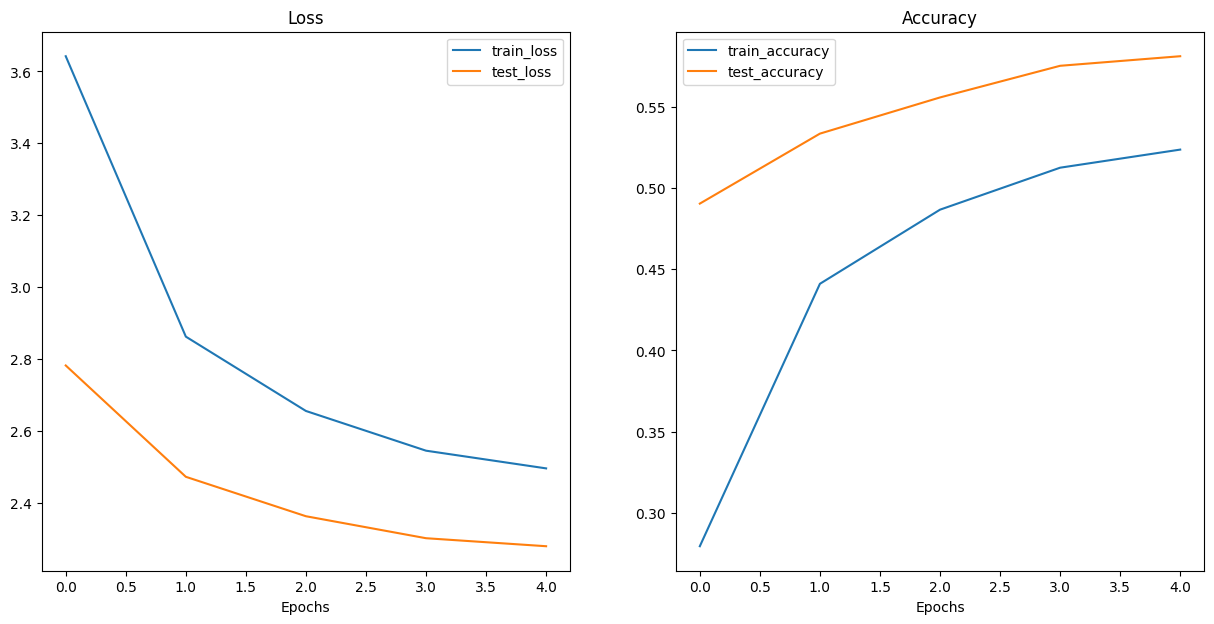

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_food101_results)


###10.7 Save and load FoodVision Big model

In [ ]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models/",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [ ]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  # 1. Setup pretrained EffNetB2 weights
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" is equivalent to saying "best available"
  # 2. Get EffNetB2 transforms
  transforms = weights.transforms()
  # 3. Setup pretrained model instance
  model = torchvision.models.efficientnet_b2(weights=weights) # could also use weights="DEFAULT"
  # 4. Freeze the base layers in the model (this will stop all layers from training)
  for param in model.parameters():
    param.requires_grad = False
  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes, bias=True))
  return model, transforms

In [ ]:
# Create Food101 compatible EffNetB2 instance
# Update num_classes to match the saved model (101 classes for Food101)
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))


<ipython-input-93-22070f54c47c>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_ex

<All keys matched successfully>

###10.8 Checking FoodVision Big model size

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")


Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


##11. Turning our FoodVision Big model into a deployable app
Why deploy a model?

Deploying a model allows you to see how your model goes in the real-world (the ultimate test set).

Let's create an outline for our FoodVision Big app:
```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

Create Foder path

In [ ]:
import shutil
from pathlib import Path

#Create FoodVision big demo path
foodvision_bit_demo_path = Path("demos/foodvision_big/")

#Remove files than might exist and create a new directorty (ถ้ามีไฟล์เก่าให้ลบและสร้างใหม่)
if foodvision_bit_demo_path.exists():
  shutil.rmtree(foodvision_bit_demo_path)
  foodvision_bit_demo_path.mkdir(parents=True, exist_ok=True)
else:
  foodvision_bit_demo_path.mkdir(parents=True, exist_ok=True)


In [ ]:
!ls demos/foodvision_big/

examples


In [ ]:
# create an examples directory
foodvision_big_examples_path = foodvision_bit_demo_path / "examples"
foodvision_big_examples_path.mkdir(parents=True, exist_ok=True)

In [ ]:
# Download and move example image
!wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpeg

--2024-11-25 15:32:51--  https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg [following]
--2024-11-25 15:32:51--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.06s   

2024-11-25 15:32:52 (44.4 MB/s) - ‘04-pizza-dad.jpeg’ saved 

In [ ]:
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big/

###11.2 Saving Food101 class names to file (class_names.txt)
Let's save all of the Food101 class names to a .txt file so we can import them and use them in our app.

In [ ]:
food101_class_name[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
#create path to Food101 class names
food101_big_class_names_path = foodvision_bit_demo_path / "class_names.txt"
food101_big_class_names_path

PosixPath('demos/foodvision_big/class_names.txt')

In [ ]:
# Write Food101 class names to text file
with open(food101_big_class_names_path, "w") as f:
  print(f"[INFO] Saving Food101 class names to {food101_big_class_names_path}")
  f.write("\n".join(food101_class_name)) # new line per class name

[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [ ]:
# Open Food101 class names file and read each line into a list
with open(food101_big_class_names_path, "r") as f:
  food101_class_names_loaded = [food.strip() for food in f.readlines()]

In [ ]:
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

###11.3 Turning our FoodVision Big model into a Python script (model.py)

In [ ]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision
from torch import nn

# Create EffNetB2 feature extractor model
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  # 1. Setup pretrained EffNetB2 weights
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" is equivalent to saying "best available"
  # 2. Get EffNetB2 transforms
  transforms = weights.transforms()
  # 3. Setup pretrained model instance
  model = torchvision.models.efficientnet_b2(weights=weights) # could also use weights="DEFAULT"
  # 4. Freeze the base layers in the model (this will stop all layers from training)
  for param in model.parameters():
    param.requires_grad = False
  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes, bias=True))
  return model, transforms


Writing demos/foodvision_big/model.py


###11.4 Turning our FoodVision Big Gradio app into a Python script (app.py)
The app.py file will have four major parts:

1. Imports and class names setup - for class names, we'll need to import from class_names.txt rather than with a Python list
2. Model and transforms preparation - we'll need to make sure our model is suitable for FoodVision Big
3. Predict function (predict()) - this can stay the same as the original predict()
4. Gradio app - our Gradio interface + launch command - this will change slightly from FoodVision Mini to reflect the FoodVision Big updates

In [ ]:
%%writefile demos/foodvision_big/app.py

# 1. imports and class names setup
import gradio as gr
import os
import torch
import torchvision

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f:
  class_names = [food.strip() for food in f.readlines()]

# 2. model and transforms preparation
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load saved weights
effnetb2_food101.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu") # load the model to the CPU
    )
)

# 3.predict function (predict())
def predict(img) -> Tuple[Dict, float]:
  # Start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2_food101.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probaiblities
    pred_probs = torch.softmax(effnetb2_food101(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  # ความน่าจะเป็นการทำนาย (prediction probability)
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

#create a example list
example_list = ["examples/" + example for example in os.listdir("examples")]
example_list

# Launch Gradio demo
title = "FoodVision Big 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify food images into 101 classes of food from food101 dataset"
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#11-turning-our-foodvision-big-model-into-a-deployable-app)."
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)
demo.launch()


Writing demos/foodvision_big/app.py


###11.5 Creating a requirements file for FoodVision Big (requirements.txt)

In [ ]:
%%writefile demos/foodvision_big/requirements.txt
torch==2.5.1
torchvision==0.20.1
gradio==5.6.0

Writing demos/foodvision_big/requirements.txt


###11.6 Downloading our FoodVision Big app files

In [ ]:
# Change into the foodvision_mini directory and then zip it from the inside
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.ipynb" "*.pyc" "*.__pycahe__" "*.ipynb_checkpoints"


  adding: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 52%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpeg (deflated 0%)
  adding: model.py (deflated 47%)
  adding: requirements.txt (deflated 4%)


In [ ]:
#Download
try:
  from google.colab import files
  files.download("demos/foodvision_big.zip")
except:
  print("Skipping file download, not on Google Colab, pls download manually!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://raksitkan-foodvision-big.hf.space/+", width=900, height=750)